# Stock Price Prediction Based on News Sentiment
- [Repository](https://github.com/hish-school-work/Math509-project)

## Group Members:
- Chetan Dhingra (1862481)
- Hish Salehi (1812352)
- Velda Iskandar (1882870)

### Step 1: Install Required Libraries

We begin by installing the necessary Python packages. `yfinance` is used to fetch historical stock data from Yahoo Finance, `pandas` for data manipulation, and `matplotlib` for future visualizations.


In [3]:
!pip install yfinance matplotlib pandas


### Step 2: Download Tesla Stock Price Data (2015–2019)

Here, we use the `yfinance` package to download daily stock data for Tesla (ticker symbol: TSLA) from January 1, 2015, to December 31, 2019. This will serve as the foundation for our analysis of how news sentiment correlates with stock price movements.


In [4]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Define Tesla stock ticker and date range
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2019-12-31"

# Fetch daily stock price data
tesla_stock = yf.download(ticker, start=start_date, end=end_date)

# Preview result
tesla_stock.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


### Step 3: Check for MultiIndex Columns

After downloading the data, we print the column structure to inspect if the DataFrame has a MultiIndex. This happens occasionally with certain formats from `yfinance`, and we’ll need to flatten the index in the next step to simplify further processing.


In [5]:
tesla_stock.columns

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

In [6]:
# Flatten MultiIndex: keep just the first level (like 'Close', 'High', etc.)
tesla_stock.columns = tesla_stock.columns.get_level_values(0)

# Reset index to bring 'Date' back as a column
tesla_stock = tesla_stock.reset_index()

# Rename column if needed
tesla_stock = tesla_stock.rename(columns={"Close": "adj_close"})

tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [7]:
# Calculate daily returns
tesla_stock['return'] = tesla_stock['adj_close'].pct_change()

# Drop NaN from the first row
tesla_stock = tesla_stock.dropna().reset_index(drop=True)

# Preview cleaned data
tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume,return
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802


In [8]:
len(tesla_stock)

1256


### Step 4: Visualize Tesla Stock Price and Returns

Before diving into sentiment modeling, we visualize Tesla’s stock performance to understand the data’s behavior. The first plot shows the adjusted close price over time, revealing long-term trends and shifts. The second plot highlights daily percentage returns, which help detect periods of high volatility. Finally, a histogram of returns allows us to assess their distribution, an important aspect for later modeling.


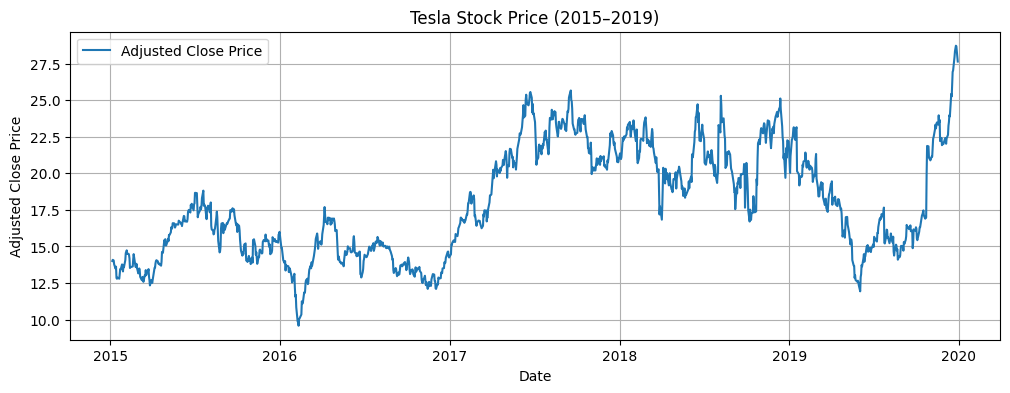

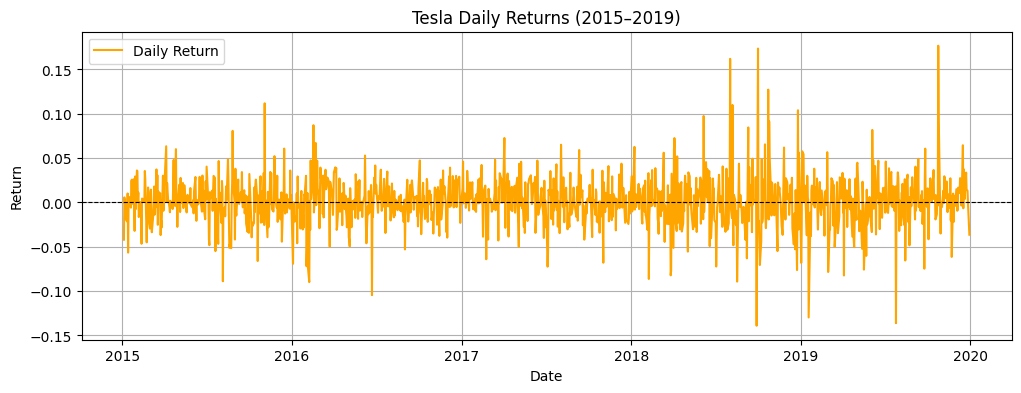

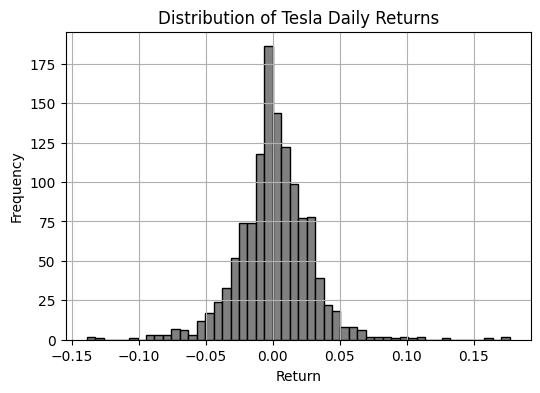

In [9]:
import matplotlib.pyplot as plt

# Plot adjusted close price
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['adj_close'], label='Adjusted Close Price')
plt.title('Tesla Stock Price (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot daily returns
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['return'], color='orange', label='Daily Return')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Tesla Daily Returns (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# Optional: histogram of returns
plt.figure(figsize=(6, 4))
plt.hist(tesla_stock['return'], bins=50, color='gray', edgecolor='black')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The plots are helpful to understand the behavior of Tesla's stock between 2015 and 2019. The adjusted close price shows a long period of relative stability followed by an abrupt spurt in late 2019, which hints at potential periods where market sentiment could have played a greater role. The plot of daily return shows consistent short-term volatility with high peaks in volatility, which are ideal for studying the impact of sentiment. Also, the return histogram exhibits a distribution about zero with small tails, which justifies the application of a normal distribution in modeling, as well as hinting at the occasional large movements. All these findings together justify the application of sentiment-based predictive modeling and motivate further investigation with Bayesian inference techniques.



### Step 5: Load and Inspect Raw Tweet Dataset

We load the full tweet dataset to examine its structure. This dataset contains tweets from multiple users between 2015 and 2019. We check the available columns to understand what information we can use, including the tweet content, time of posting, and engagement metrics like retweets and likes.


In [10]:
# Install dependencies as needed:
! pip install kagglehub[pandas-datasets]

In [11]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Tweet.csv"

# Load the latest version
tweets_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
  file_path,
)

# Preview the columns
print(tweets_df.columns)

tweets_df.head()

<ipython-input-11-e86aba183c14>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  tweets_df = kagglehub.load_dataset(


100%|██████████| 244M/244M [00:03<00:00, 64.2MB/s]

Extracting zip of Tweet.csv...


Index(['tweet_id', 'writer', 'post_date', 'body', 'comment_num', 'retweet_num',
       'like_num'],
      dtype='object')


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [18]:
len(tweets_df)

3717964

### Step 6: Filter for Tesla-Related Tweets and Parse Dates

From the full dataset, we extract only the tweets that are relevant to Tesla by searching for keywords like "TSLA", "Tesla", or "Elon Musk". Then, we convert the UNIX timestamp (`post_date`) into a readable datetime format, which allows us to align tweets with stock data on a daily basis. We preview the cleaned subset to verify that the filtering worked correctly.


In [36]:
# Filter for Tesla-related tweets (case-insensitive)
tesla_tweets = tweets_df[
    tweets_df['body'].str.contains("TSLA|Tesla|Elon Musk|EV|Electric Vehicle", case=False, na=False)
].copy()

# Convert post_date (UNIX timestamp) to datetime
tesla_tweets['date'] = pd.to_datetime(tesla_tweets['post_date'], unit='s')

# Preview cleaned Tesla tweets
tesla_tweets[['date', 'body']].head()

,date,body
3,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
5,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
6,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
7,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...


In [37]:
len(tesla_tweets)

1408049

In [89]:
# Use google drive for saved .parquet files
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sentiment Analysis

### Step 1: Preprocess Text

In [39]:
! pip install vaderSentiment tqdm pyarrow

In [40]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
import os
import re
import multiprocessing
from functools import partial

In [41]:
def preprocess_text(text):
    """
    Preprocess/align text before sentiment analysis

    Args:
        text (str): Original tweet text

    Returns:
        str: Cleaned and normalized text
    """
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtag symbols but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove special characters except emoticons
    # This pattern preserves common emoticons while removing other punctuation
    text = re.sub(r'[^\w\s:;)(><]', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def align_dataset(tweets_df, save_path=None):
    """
    Preprocess the entire dataset and save the aligned version

    Args:
        tweets_df (pd.DataFrame): Original DataFrame with tweets
        save_path (str, optional): Path to save aligned dataset

    Returns:
        pd.DataFrame: DataFrame with aligned text
    """
    print("Starting text alignment/preprocessing...")

    # Create a copy to avoid modifying the original
    aligned_df = tweets_df.copy()

    # Apply preprocessing with progress bar
    tqdm.pandas(desc="Aligning Texts")
    aligned_df['clean_text'] = aligned_df['body'].progress_apply(preprocess_text)

    # Save preprocessed data if path is provided
    if save_path:
        aligned_df.to_parquet(save_path)
        print(f"Aligned dataset saved to {save_path}")

    return aligned_df

### Step 2: Perform Sentiment Analysis

In [42]:
def analyze_sentiment(text):
    """
    Perform sentiment analysis using VADER

    Args:
        text (str): Tweet text

    Returns:
        dict: Sentiment scores
    """
    # Skip empty strings
    if not text or not isinstance(text, str):
        return {
            'vader_compound': 0,
            'vader_positive': 0,
            'vader_negative': 0,
            'sentiment_category': 'Neutral'
        }

    # Get VADER sentiment scores
    vader_analyzer = SentimentIntensityAnalyzer()
    vader_scores = vader_analyzer.polarity_scores(text)

    # Categorize sentiment
    if vader_scores['compound'] >= 0.05:
        sentiment_category = 'Positive'
    elif vader_scores['compound'] <= -0.05:
        sentiment_category = 'Negative'
    else:
        sentiment_category = 'Neutral'

    return {
        'vader_compound': vader_scores['compound'],
        'vader_positive': vader_scores['pos'],
        'vader_negative': vader_scores['neg'],
        'sentiment_category': sentiment_category
    }

def process_chunk(texts, analyzer=None):
    """Process a chunk of texts with a shared analyzer instance"""
    if analyzer is None:
        analyzer = SentimentIntensityAnalyzer()

    results = []
    for text in texts:
        if not text or not isinstance(text, str):
            results.append({
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'sentiment_category': 'Neutral'
            })
            continue

        vader_scores = analyzer.polarity_scores(text)

        if vader_scores['compound'] >= 0.05:
            sentiment_category = 'Positive'
        elif vader_scores['compound'] <= -0.05:
            sentiment_category = 'Negative'
        else:
            sentiment_category = 'Neutral'

        results.append({
            'vader_compound': vader_scores['compound'],
            'vader_positive': vader_scores['pos'],
            'vader_negative': vader_scores['neg'],
            'sentiment_category': sentiment_category
        })

    return results

def perform_sentiment_analysis(tweets_df, save_path, aligned_path=None,
                              sample_size=None, use_parallel=True, n_cores=None):
    """
    Perform sentiment analysis with optional alignment preprocessing

    Args:
        tweets_df (pd.DataFrame): DataFrame with tweet data
        save_path (str): Path to save sentiment analysis results
        aligned_path (str, optional): Path to save/load aligned dataset
        sample_size (int, optional): Number of tweets to sample for testing
        use_parallel (bool): Whether to use parallel processing
        n_cores (int, optional): Number of CPU cores to use

    Returns:
        dict: Dictionary with processed tweets and daily sentiment
    """
    # Check if saved sentiment results exist
    if os.path.exists(save_path):
        print(f"Loading existing sentiment analysis from {save_path}")
        processed_tweets = pd.read_parquet(save_path)

        # Compute daily sentiment
        daily_sentiment = processed_tweets.groupby(processed_tweets['date'].dt.date).agg({
            'vader_compound': 'mean',
            'sentiment_category': lambda x: x.value_counts().index[0],
            'body': 'count'
        }).rename(columns={'body': 'tweet_count'})

        return {
            'processed_tweets': processed_tweets,
            'daily_sentiment': daily_sentiment
        }

    # Check if aligned dataset exists or create it
    aligned_df = None
    if aligned_path and os.path.exists(aligned_path):
        print(f"Loading existing aligned dataset from {aligned_path}")
        aligned_df = pd.read_parquet(aligned_path)
    else:
        # Perform alignment
        aligned_df = align_dataset(tweets_df, save_path=aligned_path)

    # Use sample for testing if specified
    if sample_size is not None:
        working_df = aligned_df.sample(sample_size).copy()
        print(f"Using sample of {sample_size} tweets for testing")
    else:
        working_df = aligned_df.copy()

    # Use the clean_text column for sentiment analysis
    if use_parallel:
        # Determine number of cores to use
        if n_cores is None:
            n_cores = max(1, multiprocessing.cpu_count() - 1)  # Leave one core free

        print(f"Using parallel processing with {n_cores} cores")

        # Split data into chunks for parallel processing
        texts = working_df['clean_text'].tolist()
        chunk_size = max(1, len(texts) // (n_cores * 4))  # Create more chunks than cores for better load balancing
        chunks = [texts[i:i+chunk_size] for i in range(0, len(texts), chunk_size)]

        # Process chunks in parallel
        with multiprocessing.Pool(n_cores) as pool:
            results_chunks = list(tqdm(
                pool.imap(process_chunk, chunks),
                total=len(chunks),
                desc="Processing chunks"
            ))

        # Flatten results
        all_results = []
        for chunk in results_chunks:
            all_results.extend(chunk)

        # Add results to dataframe
        working_df['vader_compound'] = [r['vader_compound'] for r in all_results]
        working_df['vader_positive'] = [r['vader_positive'] for r in all_results]
        working_df['vader_negative'] = [r['vader_negative'] for r in all_results]
        working_df['sentiment_category'] = [r['sentiment_category'] for r in all_results]
    else:
        # Sequential processing with vectorization
        analyzer = SentimentIntensityAnalyzer()

        # Process in smaller batches to show progress
        batch_size = 1000
        results = []

        for i in tqdm(range(0, len(working_df), batch_size), desc="Processing batches"):
            batch = working_df['clean_text'].iloc[i:i+batch_size].tolist()
            batch_results = process_chunk(batch, analyzer)
            results.extend(batch_results)

        # Add results to dataframe
        working_df['vader_compound'] = [r['vader_compound'] for r in results]
        working_df['vader_positive'] = [r['vader_positive'] for r in results]
        working_df['vader_negative'] = [r['vader_negative'] for r in results]
        working_df['sentiment_category'] = [r['sentiment_category'] for r in results]

    # Save results
    output_path = save_path
    if sample_size is not None:
        # Indicate it's a sample
        base, ext = os.path.splitext(save_path)
        output_path = f"{base}_sample_{sample_size}{ext}"

    working_df.to_parquet(output_path, index=False)
    print(f"Sentiment analysis results saved to {output_path}")

    # Daily sentiment summary
    daily_sentiment = working_df.groupby(working_df['date'].dt.date).agg({
        'vader_compound': 'mean',
        'sentiment_category': lambda x: x.value_counts().index[0],
        'body': 'count'
    }).rename(columns={'body': 'tweet_count'})

    return {
        'processed_tweets': working_df,
        'daily_sentiment': daily_sentiment
    }

In [43]:
# Align the data (do this once)
aligned_tweets = align_dataset(
    tesla_tweets,
    save_path="aligned_tweets.parquet"
)

Starting text alignment/preprocessing...


Aligning Texts:   0%|          | 0/1408049 [00:00<?, ?it/s]

Aligned dataset saved to aligned_tweets.parquet
Loading existing aligned dataset from aligned_tweets.parquet
Using parallel processing with 8 cores


Processing chunks:   0%|          | 0/33 [00:00<?, ?it/s]

Sentiment analysis results saved to sentiment_results.parquet


In [ ]:
results = perform_sentiment_analysis(
    aligned_tweets,
    save_path="sentiment_results.parquet",
    aligned_path="aligned_tweets.parquet",  # Will load if exists, otherwise create
    use_parallel=True,
    n_cores=8
)

In [45]:
results_df = pd.DataFrame(results['daily_sentiment'])
results_df.columns

Index(['vader_compound', 'sentiment_category', 'tweet_count'], dtype='object')

In [46]:
len(results_df)

1826

## Exploratory Data Analysis (EDA)

### Sentiment Trends

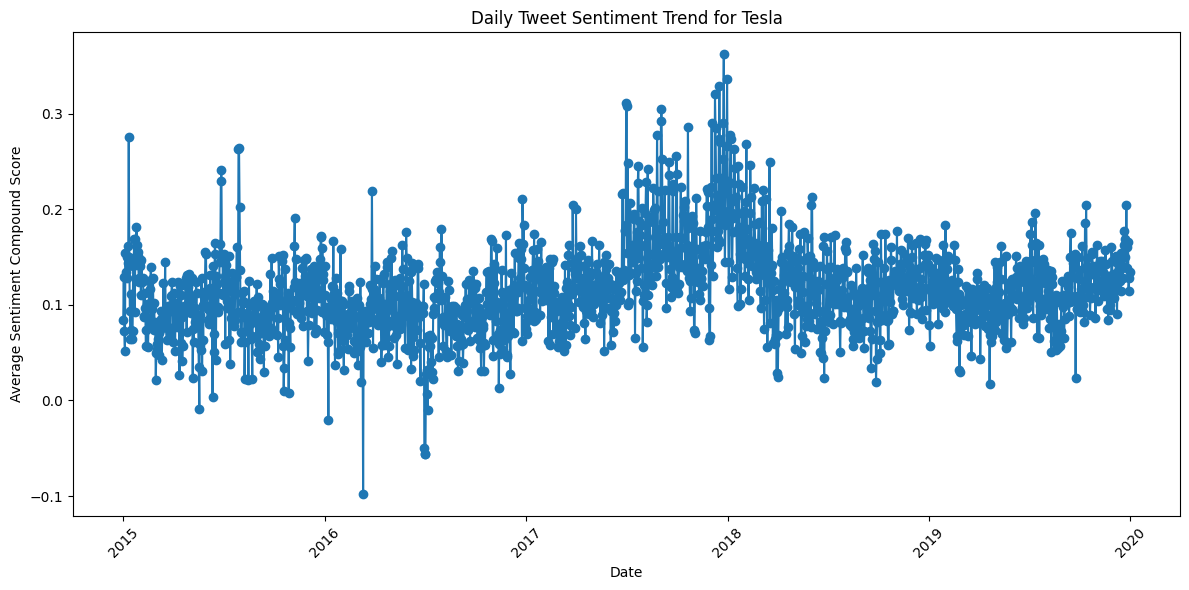

In [47]:
def plot_sentiment_trends(daily_sentiment):
    """
    Create a visualization of sentiment trends

    Args:
        daily_sentiment (pd.DataFrame): Daily sentiment summary
    """

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['vader_compound'], marker='o')
    plt.title('Daily Tweet Sentiment Trend for Tesla')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Compound Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_sentiment_trends(results['daily_sentiment'])

### Aligned sentiment data with stock prices over time

In [48]:
# Convert the index of results_df to datetime objects
results_df.index = pd.to_datetime(results_df.index)

# Convert the 'Date' column of tesla_stock to datetime objects
tesla_stock['Date'] = pd.to_datetime(tesla_stock['Date'])

# Merge the two DataFrames on the date/index
aligned_df = pd.merge(tesla_stock, results_df, how='left', left_on='Date', right_index=True)

In [49]:
# Preview the aligned DataFrame
aligned_df

,Date,adj_close,High,Low,Open,Volume,return,vader_compound,sentiment_category,tweet_count
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041,0.154244,Neutral,452
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664,0.134584,Neutral,401
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562,0.150177,Positive,425
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564,0.128108,Neutral,516
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802,0.161578,Neutral,470
...,...,...,...,...,...,...,...,...,...,...
1251,2019-12-23,27.948000,28.134001,27.333332,27.452000,199794000,0.033605,0.168890,Positive,2627
1252,2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,0.014384,0.165524,Positive,1386
1253,2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,0.013380,0.160102,Positive,1450
1254,2019-12-27,28.691999,29.020666,28.407333,29.000000,149185500,-0.001300,0.138478,Positive,1495


### Sentiment Distribution

In [50]:
import seaborn as sns
from scipy import stats

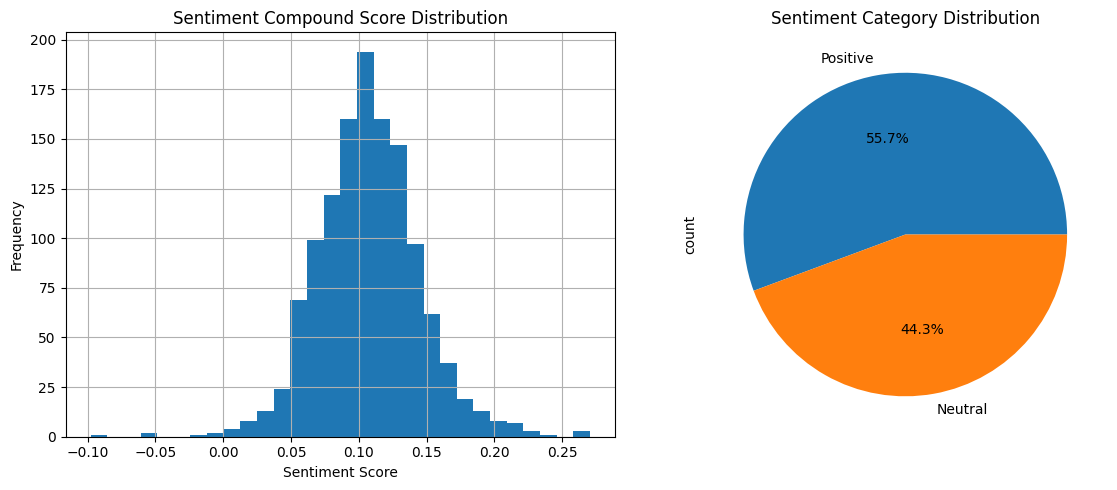

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
aligned_df['vader_compound'].hist(bins=30)
plt.title('Sentiment Compound Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
aligned_df['sentiment_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Category Distribution')
plt.tight_layout()
plt.show()

It appears that the dataset that we used for tweets is very biased towards positive sentiments and this could be because of twitter bots.

### Correlation and Relationship Analysis

Correlation Matrix:
                vader_compound  adj_close    return
vader_compound        1.000000   0.423696  0.211848
adj_close             0.423696   1.000000  0.081621
return                0.211848   0.081621  1.000000


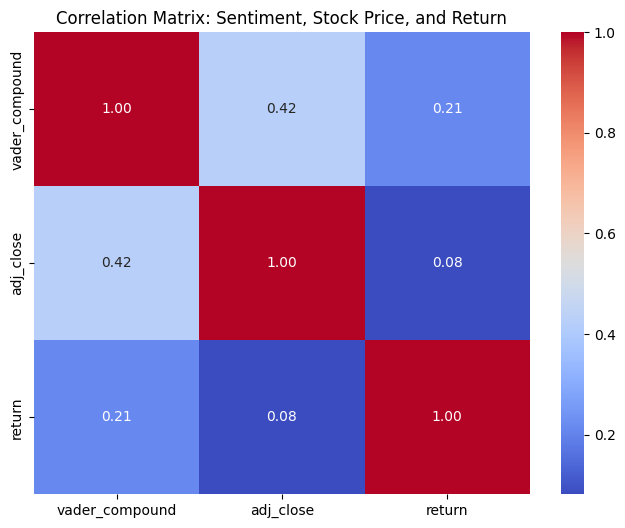

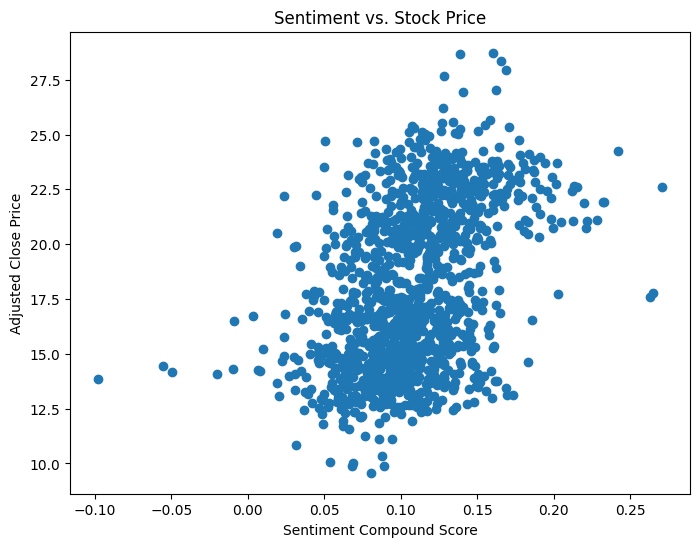

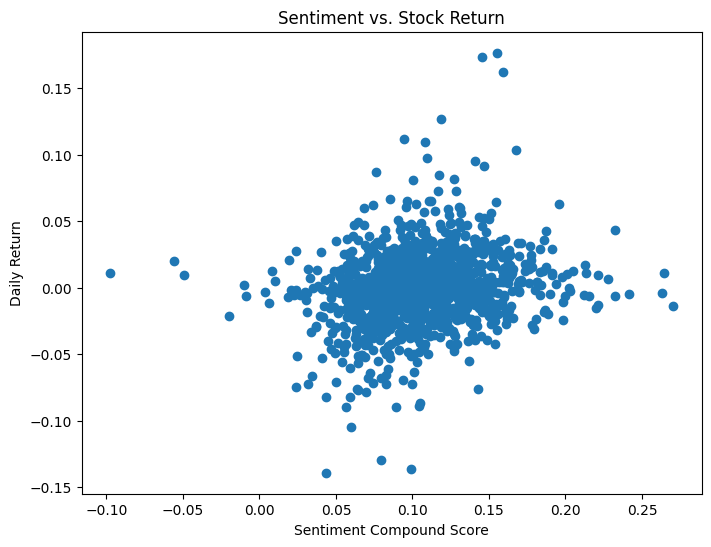

In [52]:
# Calculate the correlation between sentiment and stock metrics
correlation_matrix = aligned_df[['vader_compound', 'adj_close', 'return']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Sentiment, Stock Price, and Return')
plt.show()

# Scatter plot of sentiment vs. stock price
plt.figure(figsize=(8, 6))
plt.scatter(aligned_df['vader_compound'], aligned_df['adj_close'])
plt.title('Sentiment vs. Stock Price')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Adjusted Close Price')
plt.show()

# Scatter plot of sentiment vs. stock return
plt.figure(figsize=(8, 6))
plt.scatter(aligned_df['vader_compound'], aligned_df['return'])
plt.title('Sentiment vs. Stock Return')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Daily Return')
plt.show()

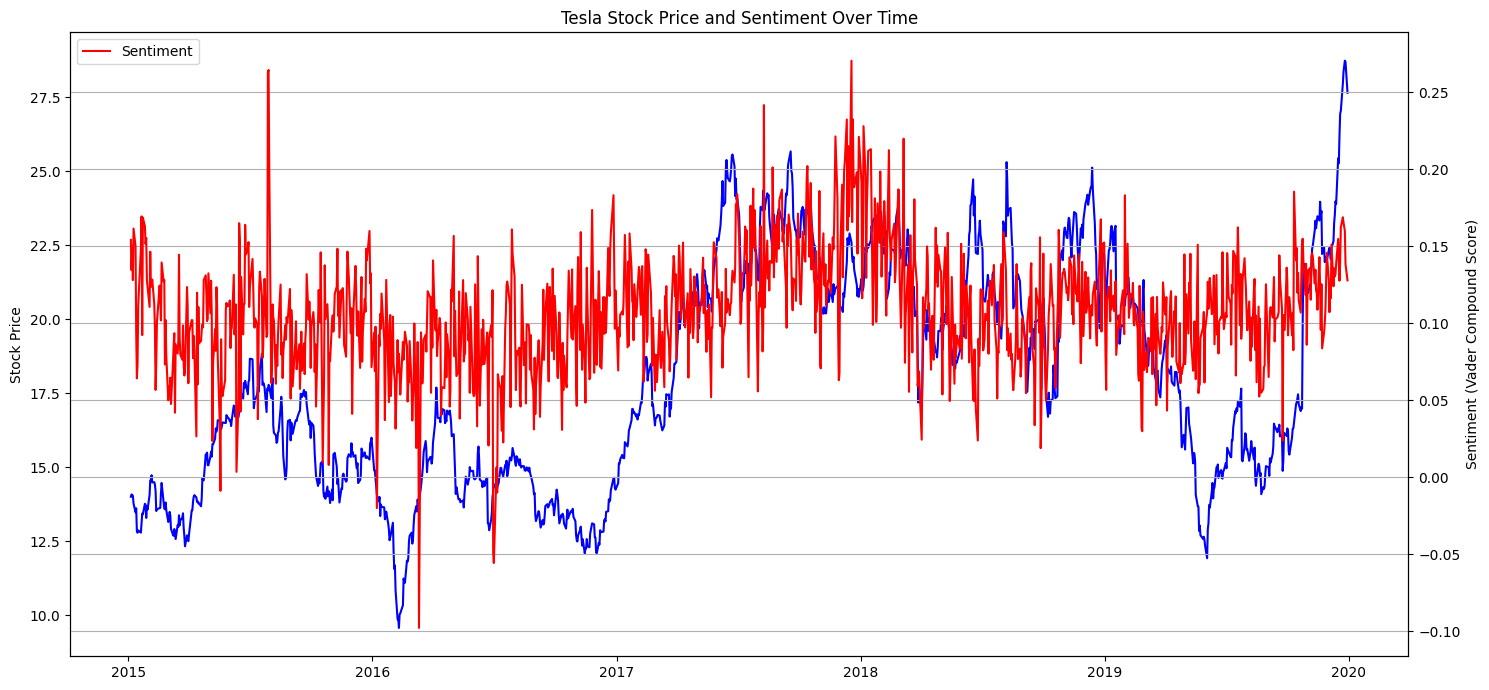

In [53]:
plt.figure(figsize=(15, 7))

# Plot stock price
plt.plot(aligned_df['Date'], aligned_df['adj_close'], label='Stock Price', color='blue')
plt.ylabel('Stock Price')

# Create a secondary y-axis for sentiment
ax2 = plt.twinx()
ax2.plot(aligned_df['Date'], aligned_df['vader_compound'], label='Sentiment', color='red')
ax2.set_ylabel('Sentiment (Vader Compound Score)')

# Customize plot
plt.title('Tesla Stock Price and Sentiment Over Time')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Time Lag Analysis
This is to analyze the results to see which lag has the highest correlation, indicating the optimal time delay between sentiment and its impact on the stock price.


In [57]:
def time_lag_analysis(df, lag_days):
    """
    Performs time lag analysis between sentiment and stock price/returns.

    Args:
        df: DataFrame with 'Date', 'adj_close', 'return', 'vader_compound' columns.
        lag_days: Number of days to lag sentiment data.

    Returns:
        A DataFrame with correlation results for each lag.
    """
    price_results = []
    return_results = []

    for lag in range(lag_days + 1):
        df_copy = df.copy()
        df_copy['lagged_sentiment'] = df_copy['vader_compound'].shift(lag)

        # Drop NaN values created by the shift
        df_copy = df_copy.dropna(subset=['lagged_sentiment'])

        price_corr = df_copy['adj_close'].corr(df_copy['lagged_sentiment'])
        return_corr = df_copy['return'].corr(df_copy['lagged_sentiment'])

        price_results.append({'Lag (days)': lag, 'Correlation': price_corr, 'Target': 'Price'})
        return_results.append({'Lag (days)': lag, 'Correlation': return_corr, 'Target': 'Return'})

    results_df = pd.DataFrame(price_results + return_results)
    return results_df

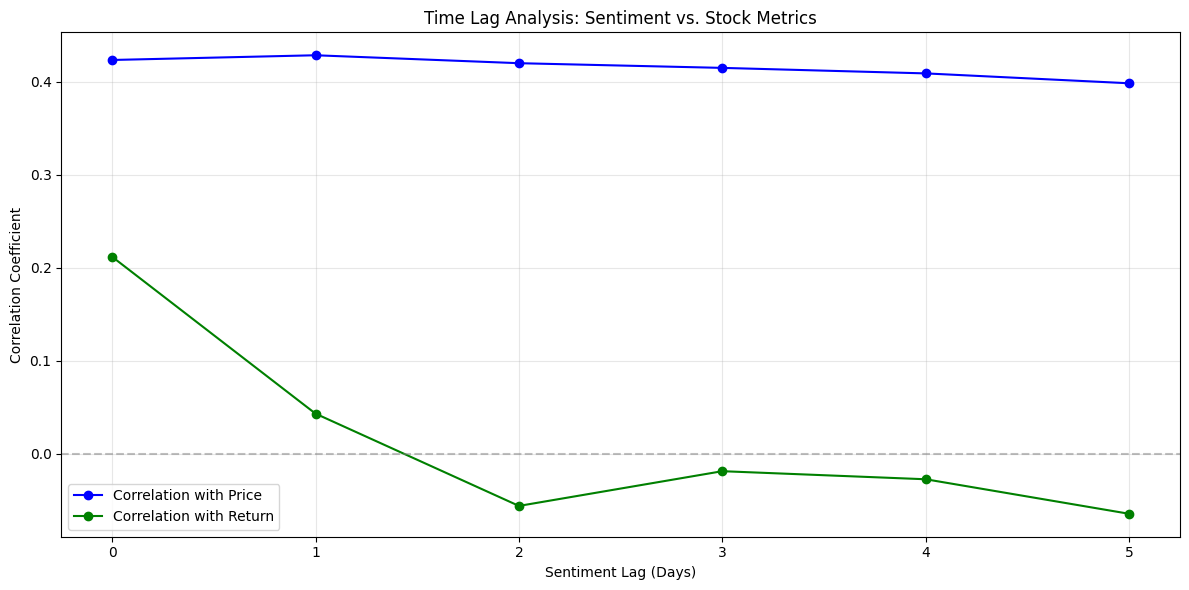

In [58]:
# Analyze lags from 0 to 5 days
lag_days_to_analyze = 5
correlation_results = time_lag_analysis(aligned_df, lag_days_to_analyze)

# Plot correlation results
plt.figure(figsize=(12, 6))

# Create separate plots for price and return correlations
for target, color in [('Price', 'blue'), ('Return', 'green')]:
    target_data = correlation_results[correlation_results['Target'] == target]
    plt.plot(target_data['Lag (days)'], target_data['Correlation'],
             marker='o', color=color, label=f'Correlation with {target}')

plt.xlabel('Sentiment Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.title('Time Lag Analysis: Sentiment vs. Stock Metrics')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Bayesian Regression Model with MCMC

### TODO

Output()

Output()

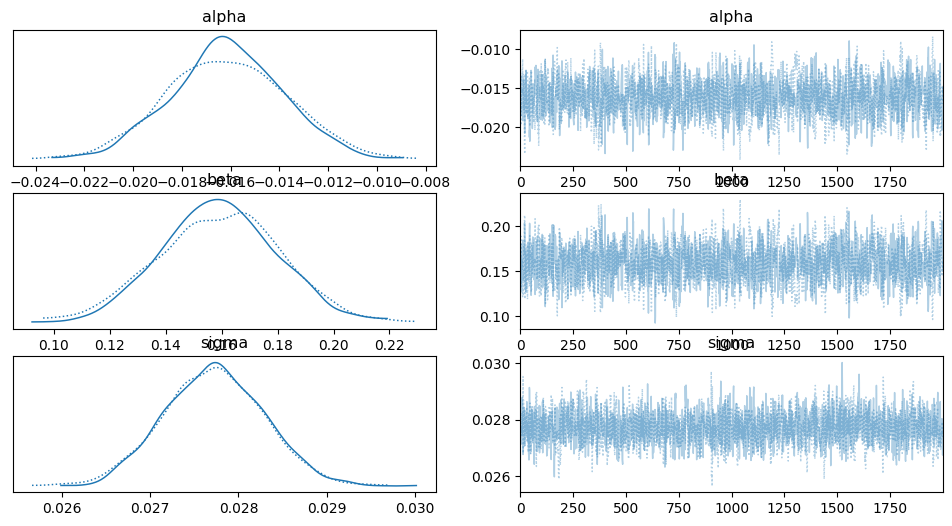

In [68]:
import pymc as pm
import arviz as az

# Prepare data for Bayesian regression
X = aligned_df['vader_compound'].values.reshape(-1, 1)  # Sentiment as predictor
y = aligned_df['return'].values  # Stock return as target

with pm.Model() as bayesian_model:
    # Prior distributions for model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept
    beta = pm.Normal('beta', mu=0, sigma=10)  # Slope for sentiment

    # Likelihood function (linear regression with Gaussian noise)
    mu = alpha + beta * X.flatten()
    sigma = pm.HalfNormal('sigma', sigma=1)  # Standard deviation of noise
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Perform MCMC sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

# Analyze posterior distributions
az.summary(trace)

# Plot posterior distributions
az.plot_trace(trace)

# Get posterior predictive samples
posterior_predictive = pm.sample_posterior_predictive(trace, model=bayesian_model)